# Alzheimer's Disease classification from anatomical MRI

### This notebook explores the use of a custom CNN to classify Alzheimer's disease from anatomical MRI images.

Briefly, the pipeline involves the following steps and technical features:

- Data formating and quality check
- Custom CNN for classification
- Hyperparameter tuning
- Final model application

### Mount AWS S3 bucket containing parquet data files

In [0]:
from helpers import mount_aws_s3_bucket

AWS_S3_BUCKET="databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/"
KEY_FILE="/FileStore/tables/brad_databricks_personal_accessKeys_new.csv"
mount_aws_s3_bucket(AWS_S3_BUCKET, KEY_FILE)

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
File <command-7802125811904479>, line 1
----> 1 from databricks_helpers import mount_aws_s3_bucket
      3 AWS_S3_BUCKET="databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/"
      4 KEY_FILE="/FileStore/tables/brad_databricks_personal_accessKeys_new.csv"

File /databricks/python_shell/lib/dbruntime/autoreload/discoverability/hook.py:81, in AutoreloadDiscoverabilityHook.pre_run_cell.<locals>.patched_import(name, *args, **kwargs)
     75 if not self._should_hint and (
     76     (module := sys.modules.get(absolute_name)) is not None and
     77     (fname := get_allowed_file_name_or_none(module)) is not None and
     78     (mtime := os.stat(fname).st_mtime) > self.last_mtime_by_modname.get(
     79         absolute_name, float("inf")) and not self._should_hint):
     80     self._should_hint = True
---> 81 module = s

### Import analysis and plotting libraries

In [0]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
import pyspark
from pyspark.sql import SparkSession
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import plot_model
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.stats import false_discovery_control
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# Parallel computing
import dask
from dask.distributed import Client, progress

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import cv2
import magic
import datetime
from IPython.display import clear_output
clear_output(wait=False)

### Load and format training data

#### Label meanings

- 0 - Mild dementia
- 1 - Moderate dementia
- 2 - No dementia
- 3 - Very mild dementia

In [0]:
Lab = ['Mild', 'Moderate', 'None', 'Very Mild']

train = pd.read_parquet("/dbfs/mnt/AD_classification/train-00000-of-00001-c08a401c53fe5312.parquet")
train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


#### Convert data to readable format

In [0]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

train['img_arr'] = train['image'].apply(dict_to_image)
train.drop("image", axis=1, inplace=True)
train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Load and format test data

In [0]:
test = pd.read_parquet("/dbfs/mnt/AD_classification/test-00000-of-00001-44110b9df98c5585.parquet")

test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)
test.head()

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Explore structure and visualization of the data

### Distribution of the datasets (are all classes represented equally?)

Text(0, 0.5, '# of images')

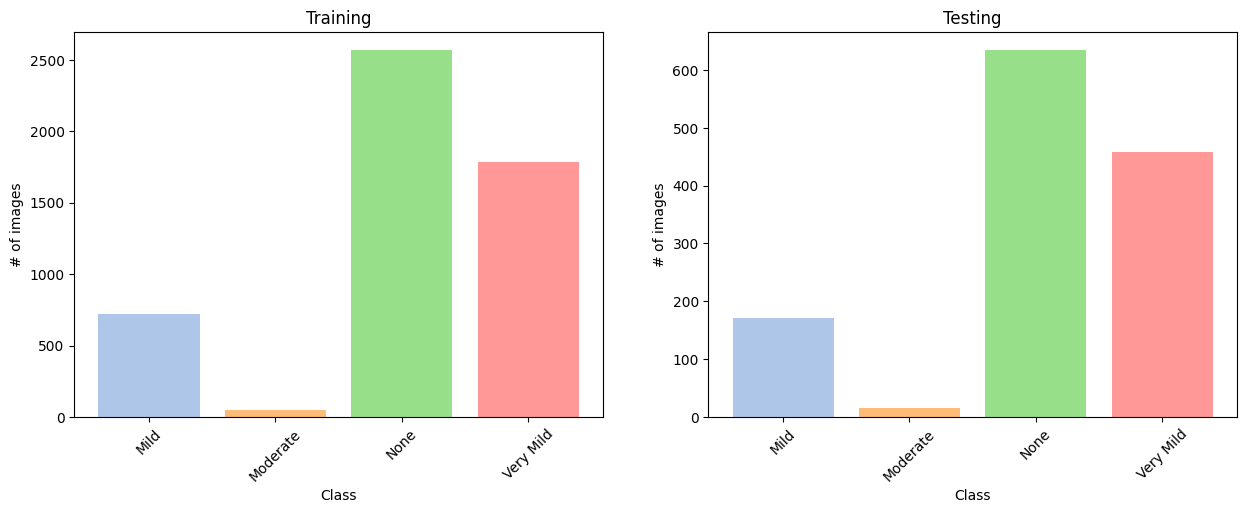

In [0]:
colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

f, ax = plt.subplots(1, 2, figsize=(15, 5))
unique, counts = np.unique(np.asarray(train.iloc[:].label), return_counts=True)
ax[0].bar(unique, counts, color=colors)
ax[0].set_xticks(unique)
ax[0].set_xticklabels(Lab, rotation=45)
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('# of images')

unique, counts = np.unique(np.asarray(test.iloc[:].label), return_counts=True)
ax[1].bar(unique, counts, color=colors)
ax[1].set_xticks(unique)
ax[1].set_xticklabels(Lab, rotation=45)
ax[1].set_title('Testing')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('# of images')

We can see that there is an obvious imbalance across classes in both the training and testing sets. However, each class has been proportionally split between the two. Nevertheless, let's attempt to balance the training set such that the model sees equal numbers of each class. To avoid overfitting (e.g. simple resampling), we use the SMOTE method here to synthetically generate new data based on what is available.

SMOTE: Synthetic Minority Over-Sampling Technique

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Text(0, 0.5, '# of images')

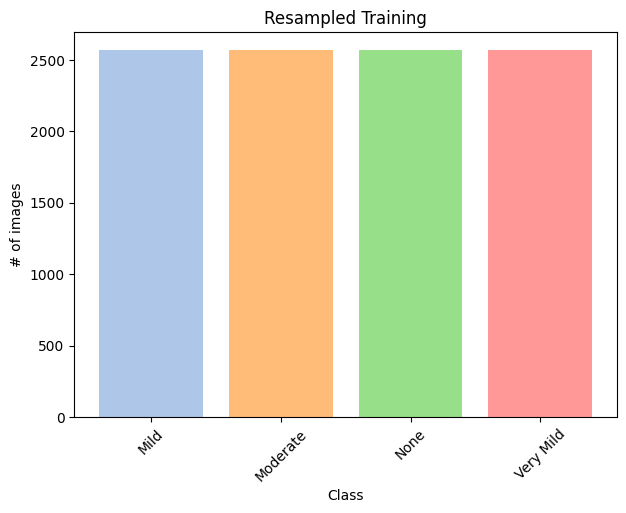

In [0]:
# Extract features and labels
X_train = np.array([img.flatten() for img in train['img_arr']])
y_train = train['label']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train.reshape(-1, 128*128), y_train)

# Reshape the resampled data back to the original image shape
X_resampled = X_resampled.reshape(-1, 128, 128)

# Create a new DataFrame with the resampled data
train_resampled = pd.DataFrame({'label': y_resampled, 'img_arr': [img.tolist() for img in X_resampled]})

# Extract labels from the resampled training data
y_resampled = train_resampled['label']

# Plot the distribution of the different classes
colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

f, ax = plt.subplots(1, 1, figsize=(7, 5))
unique, counts = np.unique(y_resampled, return_counts=True)
ax.bar(unique, counts, color=colors)
ax.set_xticks(unique)
ax.set_xticklabels(Lab, rotation=45)
ax.set_title('Resampled Training')
ax.set_xlabel('Class')
ax.set_ylabel('# of images')

Now we see that the training set is balanced across classes. Let's inspect some of the new data for quality control.

{0: 5121, 1: 6962, 2: None, 3: 9479}


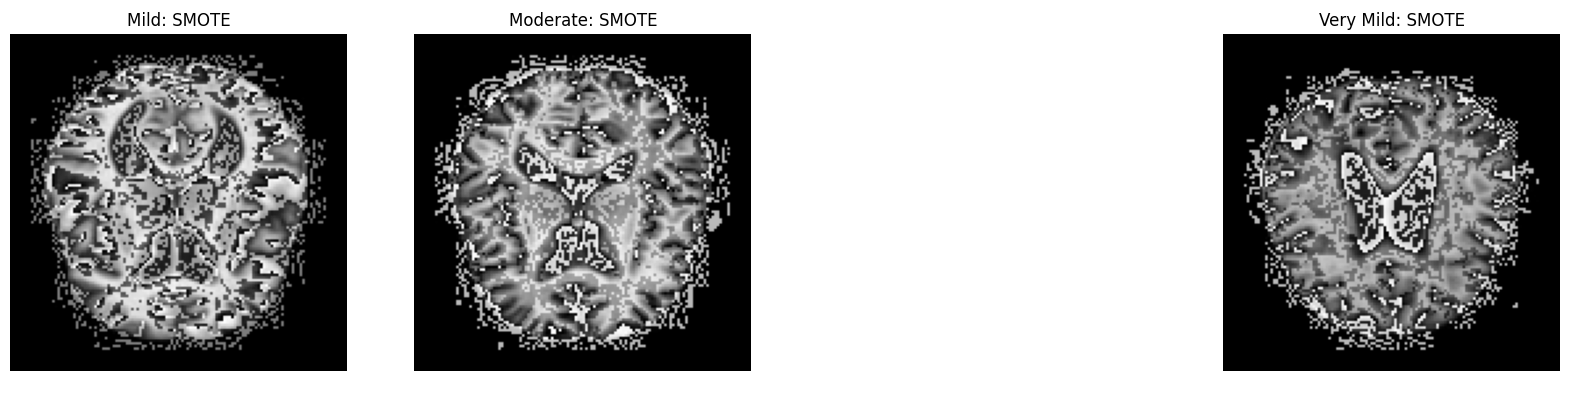

In [0]:

first_indices = {}
for num in range(0, 4):
    first_index = next((i for i, x in enumerate(y_resampled[5121:], start=5121) if x == num), None)
    first_indices[num] = first_index

print(first_indices)

# Visualize the images from the first_indices values
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, label in enumerate(np.unique(y_resampled)):
    if first_indices[label] is not None:
        first_image = np.array(train_resampled.iloc[first_indices[label]]['img_arr']).reshape(128, 128)
        ax[i].imshow(first_image, cmap='gray')
        ax[i].set_title(f"{Lab[label]}: SMOTE")
    ax[i].axis('off')

Visually inspect original data

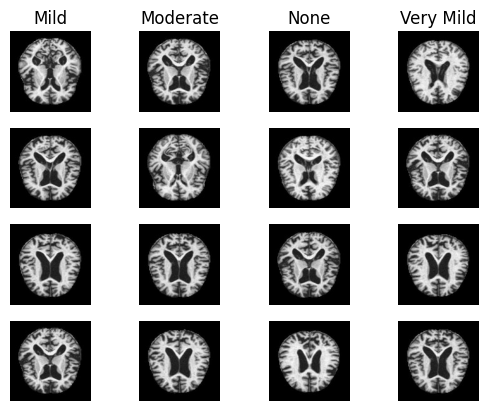

In [0]:
train_lab_idx = np.asarray(train.iloc[:].label)

f, ax = plt.subplots(4,4)
for lab in range(4):
    for ex in range(4):
    
        class_lab = np.argwhere(train_lab_idx == 1)
        current_idx = np.random.randint(len(class_lab)-1,size = 1)
        current_idx = np.asarray(current_idx)
        
        ax[ex, lab].axis('off')
        ax[ex, lab].imshow(train.iloc[class_lab[current_idx[0]][0]].img_arr, cmap = "gray")
        if ex == 0: ax[ex, lab].set_title(Lab[lab])

# Clearly, images show different slices within the brain, which may be a major confound...

Format images (stored in local memory)

In [0]:
# training data
train_data = np.empty((len(train), 128, 128))
for i in range(len(train)):
   train_data[i, :, :] = train.iloc[i].img_arr

# test data
test_data = np.empty((len(test), 128, 128))
for i in range(len(test)):
   test_data[i, :, :] = test.iloc[i].img_arr

# format in 3D shape that keras likes
train_data = np.expand_dims(train_data, axis = 3)
test_data = np.expand_dims(test_data, axis = 3)
train_data.shape

(5120, 128, 128, 1)

Data augmentation

In [0]:
# Resize and rescale functions
IMG_SIZE = 128
resize_and_rescale = keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle = False, augment =False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls = AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training = True), y),
                num_parallel_calls = AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size = AUTOTUNE)

clear_output(wait=False)

### Augment training dataset only

Verify augmentation on first image

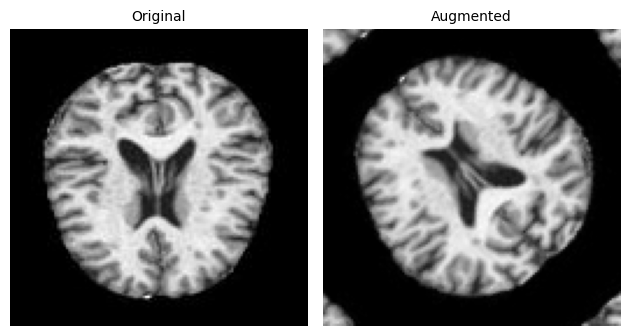

In [0]:
# sample dataset
train_data_tmp = train_data[0]
train_data_tmp = np.expand_dims(train_data_tmp, axis = 0)

# apply augmentation
train_ds = tf.data.Dataset.from_tensor_slices((train_data_tmp, train_lab_idx[:1]))
train_ds = prepare(train_ds, shuffle=True, augment=True)

# view augmented images
train_ds = train_ds.unbatch()
images = np.asarray(list(train_ds.map(lambda x, y: x)))
clear_output(wait=False)

f, ax = plt.subplots(1,2)
ax[0].axis('off')
ax[0].imshow(train_data[0], cmap = "gray",)
ax[0].set_title('Original', fontsize = 10)

ax[1].axis('off')
ax[1].imshow(images[0,:,:,:], cmap = "gray",)
ax[1].set_title('Augmented', fontsize = 10)
plt.tight_layout()


### Augment multiple times to generate larger training set

In [0]:
import boto3
import os

s3 = boto3.client('s3')
bucket_name = 'your-bucket-name'
file_key = 'CNN - train_data_augment'

try:
    s3.head_object(Bucket=bucket_name, Key=file_key)
    file_exists = True
except:
    file_exists = False

if not file_exists:
    train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_lab_idx))
    train_ds_for_aug = train_ds

    for i in range(1):
        train_aug = prepare(train_ds_for_aug, shuffle=True, augment=True)
        train_aug = train_aug.unbatch()
        train_aug = train_aug.map(lambda x, y: (tf.cast(x, tf.float64), y))
        train_ds = train_ds.concatenate(train_aug)

    del train_aug, train_ds_for_aug
    images = np.asarray(list(train_ds.map(lambda x, y: x)))
    labels = np.asarray(list(train_ds.map(lambda x, y: y)))
    clear_output(wait=False)
    print(images.shape)

    np.savez('/dbfs/tmp/train_data_augment.npz', images=images, labels=labels)
    s3.upload_file('/dbfs/tmp/train_data_augment.npz', bucket_name, file_key)
else:
    local_file_path = '/dbfs/tmp/train_data_augment.npz'
    s3.download_file(bucket_name, file_key, local_file_path)
    data = np.load(local_file_path)
    images = data['images']
    labels = data['labels']

(10240, 128, 128, 1)


## Custom CNN for classification

In [0]:
# three convolutional layers and one fully connected layer
model = keras.Sequential([
    keras.Input(shape = (128, 128, 1)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = 'relu'), # fully connected layer
    keras.layers.Dense(4, activation = 'softmax')
])

### Compile model

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,484 (24.86 MB)

 Trainable params: 6,516,484 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

### Fit model

In [0]:
experiment_log_dir = "/dbfs/FileStore/logs/"
run_log_dir = experiment_log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_log_dir, histogram_freq=1, write_graph=True, write_images=True)

train_lab = to_categorical(train_lab_idx.astype('int8'))
history = model.fit(train_data, train_lab, epochs=20, batch_size=32, callbacks=[tensorboard_callback])

Epoch 1/20
131/160[

*** WARNING: max output size exceeded, skipping output. ***

160/160 ━━━━━━━━━━━━━━━━━━━━ 176s 894ms/step - accuracy: 0.9844 - loss: 0.0465


In [0]:
# %load_ext tensorboard
# %tensorboard --logdir $run_log_dir

Tensorboard may not be displayed in the notebook cell output when 'Third-party iFraming prevention' is disabled. You can still use Tensorboard by clicking the link below to open Tensorboard in a new tab. To enable Tensorboard in notebook cell output, please ask your workspace admin to enable 'Third-party iFraming prevention'.


Launching TensorBoard...

Open in a new tab
 
 Note: TensorBoard is only available when this notebook remains attached to the cluster. 
 
 
 Note: This cell needs to be re-run for TensorBoard to be available if this notebook is imported into a different workspace.

### visualize model fit

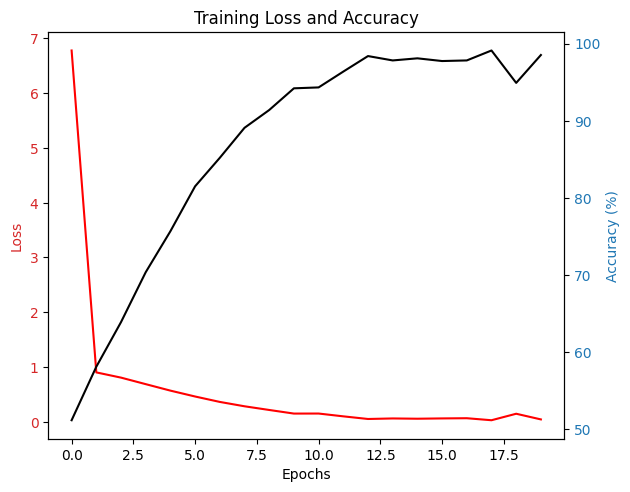

In [0]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(history.history['loss'], 'r', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:blue')
ax2.plot(np.array(history.history['accuracy']) * 100, 'k', label='Accuracy (%)')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.title('Training Loss and Accuracy')
plt.show()

### Predict test data

In [0]:
prob = model.predict(test_data)
predict_classes=np.argmax(prob,axis=1)
predict_classes

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step


array([3, 0, 2, ..., 3, 2, 3])

Evaluate accuracy and visualize

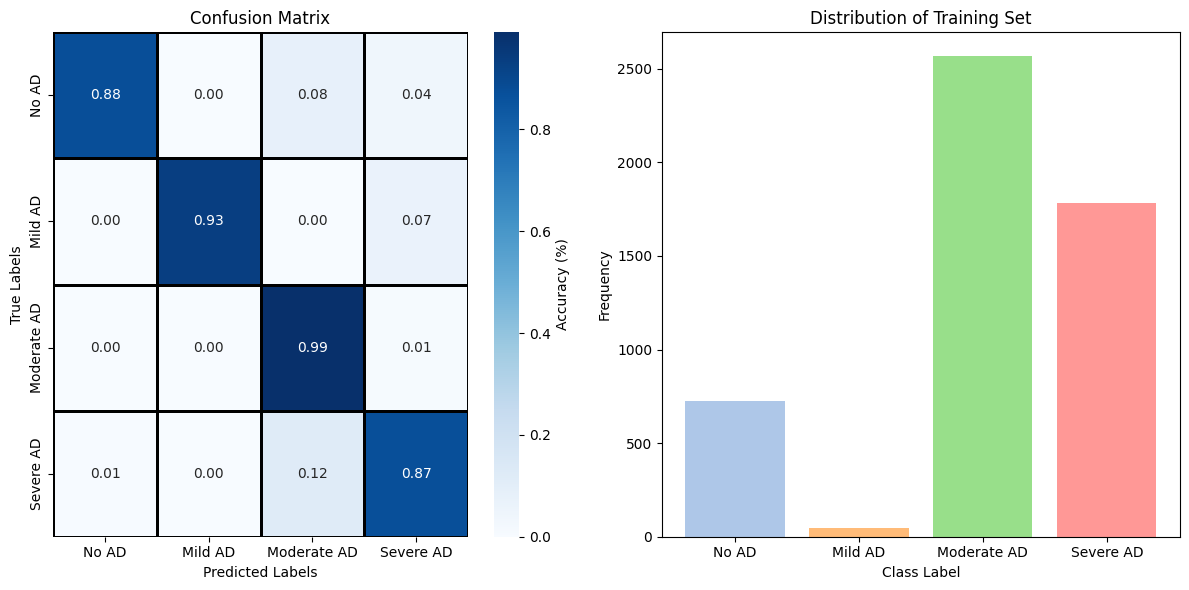

In [0]:
# Generate and plot confusion matrix
test_lab_idx = np.asarray(test.iloc[:].label)
conf_matrix = confusion_matrix(test_lab_idx, predict_classes)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Accuracy (%)'}, 
            xticklabels=['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'], 
            yticklabels=['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'], 
            ax=ax[0], linewidths=1, linecolor='black')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')
ax[0].set_title('Confusion Matrix')

# Bar plot for the distribution of the test set
train_label_counts = train['label'].value_counts().sort_index()
ax[1].bar(train_label_counts.index, train_label_counts.values, color = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896'])
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Training Set')
ax[1].set_xticks(train_label_counts.index)
ax[1].set_xticklabels(['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'])

plt.tight_layout()
plt.show()

Overall we do not see a direct link between the test set class accuracies and the number of measurements in the training set. In fact the class with the lowest number of training measurements achieved the second highest accuracy. Therefore, even though it would be ideal to have completely (or moreso) balanced training classes, this is not a major bias in the current model.

### Hyperparameter tuning

Define parameters to tune and the corresponding parameter space

In [0]:
# Same architecture as before, but with hyperparameter ranges
def build_model(hp):

    model = keras.Sequential([
    keras.Input(shape = (128, 128, 1)),  
        
    keras.layers.Conv2D(
        filters = hp.Int('conv_1_filter', min_value = 32, max_value = 128, step = 32), 
        kernel_size = hp.Choice('conv_1_kernel', values = [3,3]), 
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_2_filter', min_value = 64, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_2_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_3_filter', min_value = 96, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_3_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D((2, 2)),
        
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value = 128, max_value = 256, step = 32),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
        
    keras.layers.Dropout(0.5),
        
    keras.layers.Dense(4, activation = 'softmax')
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

### Initiate tuner

In [0]:
tuner = kt.Hyperband(build_model, objective = 'val_accuracy', max_epochs = 10, factor = 3, directory = 'my_dir', project_name = 'AD_class')
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

Reloading Tuner from my_dir/AD_class/tuner0.json


### Run search

In [0]:
# need numpy arrays rather than tensors for tuner
train_images = np.asarray(list(train_ds.map(lambda x, y: x)))
train_labels = np.asarray(list(train_ds.map(lambda x, y: y)))
train_labels = to_categorical(train_labels.astype('int8'))

test_lab_idx = np.asarray(test.iloc[:].label)
test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_lab_idx))
test_images = np.asarray(list(test_ds.map(lambda x, y: x)))
test_labels = np.asarray(list(test_ds.map(lambda x, y: y)))
test_labels = to_categorical(test_labels.astype('int8'))

tuner.search(train_images, train_labels, epochs = 10, callbacks = [stop_early],
             validation_data = (test_images, test_labels))

---------------------------------------------------------------------------
The Python process exited with exit code 137 (SIGKILL: Killed). This may have been caused by an OOM error. Check your command's memory usage.



The last 10 KB of the process's stderr and stdout can be found below. See driver logs for full logs.
---------------------------------------------------------------------------
Last messages on stderr:
Sat Dec 28 18:35:07 2024 Connection to spark from PID  1276
Sat Dec 28 18:35:07 2024 Initialized gateway on port 35111
Sat Dec 28 18:35:09 2024 Connected to spark.
2024/12/28 18:35:25 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of langchain. If you encounter errors during autologging, try upgrading / downgrading langchain to a supported version, or try upgrading MLflow.
2024/12/28 18:35:29 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of openai. If you encounter errors during autologging, try upgrading / dow

In [0]:
# Optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
Optimal parameters are as follows:

Filter 1 output dim: {best_hps.get('conv_1_filter')}
Filter 2 output dim: {best_hps.get('conv_2_filter')}
Filter 2 output dim: {best_hps.get('conv_3_filter')}

Dense layer units: {best_hps.get('units')}

Learning Rate: {best_hps.get('learning_rate')}
""")

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:717)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

Optimal # of epochs

In [0]:
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(train_images, train_labels, epochs = 50, validation_split = 0.2)

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))